# Прекод



# Сборный проект-4



Вам поручено разработать демонстрационную версию поиска изображений по запросу.



Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.



### Описание данных



Данные лежат в папке `/datasets/image_search/`.



В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.



В папке `train_images` содержатся изображения для тренировки модели.



В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:



1. Имя файла изображения.

2. Идентификатор описания.

3. Доля людей, подтвердивших, что описание соответствует изображению.

4. Количество человек, подтвердивших, что описание соответствует изображению.

5. Количество человек, подтвердивших, что описание не соответствует изображению.



В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:



1. Имя файла изображения.

2. Идентификатор описания.



3, 4, 5 — оценки трёх экспертов.



Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.



В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.



В папке `test_images` содержатся изображения для тестирования модели.

In [ ]:
!rm -rf /content/to_upload/
!rm -rf /content/__MACOSX/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q /content/drive/MyDrive/dsplus_integrated_project_4.zip

Mounted at /content/drive


In [ ]:
!pip install -q  transformers
!pip install -q opencv-python

     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 64.3 MB/s 
     |████████████████████████████████| 182 kB 81.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import cv2 as cv
from sklearn.model_selection import GroupShuffleSplit
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import  Dense, Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import torch
import transformers
from tqdm import notebook
import matplotlib.pyplot as plt

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [ ]:
expert_annotations = pd.read_csv('to_upload/ExpertAnnotations.tsv',
                                 sep='\t', 
                                 header=None,
                                 names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
expert_annotations.head()

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [ ]:
expert_annotations.shape

(5822, 5)

Моя идея агрегации оценок - взять среднее от оценок экспертов и получевшее число масштабировать как процент от 3 (кол-во экспертов). Соотвественно, чем процент выше, тем больше соотвествие

In [ ]:
expert_annotations = expert_annotations[~((expert_annotations.expert_1 != expert_annotations.expert_2) & (expert_annotations.expert_1 != expert_annotations.expert_3) & (expert_annotations.expert_2 != expert_annotations.expert_3))].reset_index(drop=True)
expert_annotations.shape

(5696, 5)

In [ ]:
expert_annotations['points'] = (expert_annotations[['expert_1', 'expert_2', 'expert_3']].mode(axis=1) - 1)/3
expert_annotations.head()

,image,query_id,expert_1,expert_2,expert_3,points
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.000000


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
train_dataset = pd.read_csv('to_upload/train_dataset.csv')
print(train_dataset.shape)
train_dataset.head()

(5822, 3)


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [ ]:
searchfor = ['child', 'children', 'boy', 'girl', 'baby', 'babies']
train_dataset = train_dataset[~train_dataset.apply(lambda series: series.str.contains('|'.join(searchfor))).any(axis=1)]
print(train_dataset.shape)
train_dataset.head()

(4402, 3)


,image,query_id,query_text
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .


In [ ]:
train_dataset = train_dataset.merge(expert_annotations, on=['image', 'query_id'])
print(train_dataset.shape)
train_dataset.head()

(4309, 7)


,image,query_id,query_text,expert_1,expert_2,expert_3,points
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,1,2,0.000000
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,2,2,0.333333
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,2,2,2,0.333333
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,2,2,0.333333
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,1,2,0.000000


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
backbone = ResNet50(input_shape= (224, 224, 3),
                    weights='imagenet',
                    include_top= False)

resnet_model = Sequential()
resnet_model.add(backbone)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def get_image_embedding(image_path):
  with Image.open(os.path.join("/content/to_upload/train_images/", image_path)) as img:
    img = img.resize((224,224))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
  return resnet_model.predict(preprocessed_img).flatten()

image_embeddings = {image_path: get_image_embedding(image_path) for image_path in train_dataset['image'].unique()}

1/1 [==============================] - 0s 23ms/step


In [ ]:
train_dataset['image_embedding'] = train_dataset['image'].map(image_embeddings)
train_dataset.head()

,image,query_id,query_text,expert_1,expert_2,expert_3,points,image_embedding
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,1,2,0.000000,"[0.049979776, 0.0, 0.0, 2.0911744, 0.0, 0.0019..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,2,2,0.333333,"[0.14211805, 0.09069523, 0.0, 1.5814041, 0.753..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,2,2,2,0.333333,"[0.12582143, 0.4515166, 0.001458095, 0.583258,..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,2,2,0.333333,"[0.0148347495, 0.291599, 0.17984468, 0.5174965..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,1,2,0.000000,"[0.9849838, 0.91064984, 0.0, 0.69013464, 0.035..."


## 4. Векторизация текстов



Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:



- tf-idf

- word2vec

- \*трансформеры (например Bert)



\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, do_basic_tokenize=True)

tokenized = train_dataset['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased').to('cuda')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = bert_model(batch.cuda(), attention_mask=attention_mask_batch.cuda())

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
text_embeddings = np.concatenate(embeddings)
train_dataset = train_dataset.loc[:4299]
print(text_embeddings.shape)
train_dataset['query_embedding'] = np.nan
train_dataset['query_embedding'] = train_dataset['query_embedding'].astype('object')
for i in range(text_embeddings.shape[0]):
  train_dataset.at[i, 'query_embedding'] = text_embeddings[i]
train_dataset.head()

(4300, 768)


<ipython-input-18-c58492fcfb9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['query_embedding'] = np.nan
<ipython-input-18-c58492fcfb9c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['query_embedding'] = train_dataset['query_embedding'].astype('object')


,image,query_id,query_text,expert_1,expert_2,expert_3,points,image_embedding,query_embedding
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,1,2,0.000000,"[0.049979776, 0.0, 0.0, 2.0911744, 0.0, 0.0019...","[0.22594438, -0.1477708, -0.41042715, 0.009856..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,2,2,0.333333,"[0.14211805, 0.09069523, 0.0, 1.5814041, 0.753...","[0.22594438, -0.1477708, -0.41042715, 0.009856..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,2,2,2,0.333333,"[0.12582143, 0.4515166, 0.001458095, 0.583258,...","[0.22594438, -0.1477708, -0.41042715, 0.009856..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,2,2,0.333333,"[0.0148347495, 0.291599, 0.17984468, 0.5174965...","[0.22594438, -0.1477708, -0.41042715, 0.009856..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,1,1,2,0.000000,"[0.9849838, 0.91064984, 0.0, 0.69013464, 0.035...","[0.22594438, -0.1477708, -0.41042715, 0.009856..."


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
train_dataset['combined_embedding'] = train_dataset.apply(lambda x: np.hstack((x['image_embedding'], x['query_embedding'])), axis=1)
train_dataset = train_dataset.drop(['query_text', 
                                    'expert_1', 
                                    'expert_2', 
                                    'expert_3',
                                    'image_embedding', 
                                    'query_embedding'], axis=1)
train_dataset.head()

NameError: ignored

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=train_dataset.drop(columns=['image','query_id', 'points']), y=train_dataset['points'], groups=train_dataset['image']))
train_df, test_df = train_dataset.loc[train_indices], train_dataset.loc[test_indices]

In [ ]:
features_train= np.array([np.float32(val) for val in train_df['combined_embedding']])
target_train= np.array(train_df['points'].values)
features_valid = np.array([np.float32(val) for val in test_df['combined_embedding']])
target_valid= np.array(test_df['points'].values)

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(2816,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [ ]:
print("Fit model on training data")
history = model.fit(
    features_train,
    target_train,
    batch_size=32,
    epochs=100,
    validation_data=(features_valid, target_valid),
)

Fit model on training data
Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 0.1275 - mse: 0.1275 - mae: 0.2714 - val_loss: 0.0744 - val_mse: 0.0744 - val_mae: 0.2077
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0735 - mse: 0.0735 - mae: 0.2105 - val_loss: 0.0802 - val_mse: 0.0802 - val_mae: 0.2375
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0704 - mse: 0.0704 - mae: 0.2038 - val_loss: 0.0824 - val_mse: 0.0824 - val_mae: 0.2429
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0628 - mse: 0.0628 - mae: 0.1918 - val_loss: 0.0782 - val_mse: 0.0782 - val_mae: 0.1981
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0609 - mse: 0.0609 - mae: 0.1887 - val_loss: 0.0826 - val_mse: 0.0826 - val_mae: 0.2003
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0548 - mse: 0.0548 - mae: 0.1770 - val_loss: 0.0702 - val_mse: 0.0702 - val_mae: 0.

## 7. Тестирование модели



Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
test_dataset = pd.read_csv('/content/to_upload/test_images.csv')
test_dataset.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [ ]:
def get_image_embedding(image_path):
  with Image.open(os.path.join("/content/to_upload/test_images/", image_path)) as img:
    img = img.resize((224,224))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
  return resnet_model.predict(preprocessed_img).flatten()

image_embeddings = {image_path: get_image_embedding(image_path) for image_path in test_dataset['image'].unique()}
test_dataset['image_embedding'] = test_dataset['image'].map(image_embeddings)
test_dataset.head()

1/1 [==============================] - 0s 20ms/step


,image,image_embedding
0,3356748019_2251399314.jpg,"[0.18399425, 1.1045403, 0.011727499, 0.1102197..."
1,2887171449_f54a2b9f39.jpg,"[0.48075712, 1.1690251, 0.06461598, 2.3638659,..."
2,3089107423_81a24eaf18.jpg,"[0.010042693, 1.4988914, 0.0076460643, 0.50235..."
3,1429546659_44cb09cbe2.jpg,"[0.12472319, 0.402425, 0.14015263, 0.08328761,..."
4,1177994172_10d143cb8d.jpg,"[0.18708052, 0.8233012, 0.104246706, 0.4910900..."


In [ ]:
test_queries = pd.read_csv('/content/to_upload/test_queries.csv', sep='|')
test_queries = test_queries.drop('Unnamed: 0', axis=1)
print(test_queries.shape)
test_queries.head()

(500, 3)


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [ ]:
test_queries = test_queries[~test_queries.apply(lambda series: series.str.contains('|'.join(searchfor))).any(axis=1)]
print(test_queries.shape)
test_queries.head()

(351, 3)


,query_id,query_text,image
10,123997871_6a9ca987b1.jpg#0,Girls wearing sports uniforms and eye protecti...,123997871_6a9ca987b1.jpg
11,123997871_6a9ca987b1.jpg#1,Several female lacrosse players are going afte...,123997871_6a9ca987b1.jpg
13,123997871_6a9ca987b1.jpg#3,The woman lacrosse player in blue is about to ...,123997871_6a9ca987b1.jpg
14,123997871_6a9ca987b1.jpg#4,Women play lacrosse .,123997871_6a9ca987b1.jpg
15,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg


In [ ]:
test_queries_sample = test_queries.sample(n=10)
test_queries_sample

,query_id,query_text,image
435,424307754_1e2f44d265.jpg#0,A black dog jumps into the air to get a treat ...,424307754_1e2f44d265.jpg
400,3601978895_9fec23ce0c.jpg#0,a man leans against a large robot .,3601978895_9fec23ce0c.jpg
410,3690425778_3b390b3ea5.jpg#0,A man jumps off of a dock and into the water .,3690425778_3b390b3ea5.jpg
411,3690425778_3b390b3ea5.jpg#1,A person jumping off a dock into water .,3690425778_3b390b3ea5.jpg
441,440190907_bf8b7ba8ef.jpg#1,many people walk through the store .,440190907_bf8b7ba8ef.jpg
233,3119913014_688d4997d7.jpg#3,A man who is dressed like a wrestler walks whi...,3119913014_688d4997d7.jpg
166,2714674623_8cd05ac114.jpg#1,"A man with a black shirt that says "" Genetic F...",2714674623_8cd05ac114.jpg
379,3514297698_0512623955.jpg#4,A spotted dog stands on his hind legs to catch...,3514297698_0512623955.jpg
446,572618443_647483ca82.jpg#1,A shirtless male looks to his right while wate...,572618443_647483ca82.jpg
169,2714674623_8cd05ac114.jpg#4,"Three people , one wearing a t-shirt and baseb...",2714674623_8cd05ac114.jpg


Функция векторизации запроса

In [ ]:
def query2vec(query):
  tokenized = tokenizer.encode(query, add_special_tokens=True, truncation=True, max_length=512)
  max_len = 512

  query_padded = torch.as_tensor(tokenized)

  query_attention_mask = torch.as_tensor(np.where(query_padded != 0, 1, 0))
  with torch.no_grad():
      query_embeddings = bert_model(query_padded.unsqueeze(0).cuda(), attention_mask=query_attention_mask.unsqueeze(0).cuda())
  return np.concatenate(query_embeddings[0][:,0,:].cpu().numpy())


In [ ]:
query_token = query2vec(test_queries_sample.iloc[0, 2])

combined_embedding = np.hstack((query_token, test_dataset.iloc[0,1])).reshape(1, -1)
print(combined_embedding.shape)
combined_embedding

(1, 2816)


array([[-0.4480005 , -0.20939675, -0.18382987, ...,  1.1700013 ,
         1.7020712 ,  0.        ]], dtype=float32)

In [ ]:
def predicting_per_pair(image_vector, query_vector):
  combined_embedding = np.hstack((query_vector, image_vector)).reshape(1, -1)
  return model.predict(combined_embedding)

predicting_per_pair(query2vec(test_queries_sample.iloc[0, 2]), test_dataset.iloc[0,1])

1/1 [==============================] - 0s 16ms/step


array([[0.17238948]], dtype=float32)

Пробуем отправить тестовый запрос

In [ ]:
test_queries_sample.iloc[3, 1]

'A person jumping off a dock into water .'

1/1 [==============================] - 0s 14ms/step


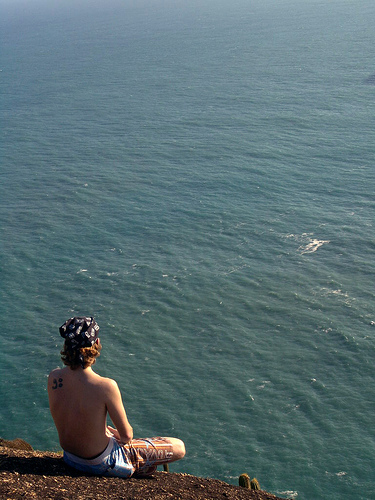

In [ ]:
def get_image_for_query(images, query):
    query_token = query2vec(query)
    images_temp = images.copy()
    images_temp['similarity'] = np.nan
    images_temp['similarity'] = images_temp['similarity'].astype('object')
    for index, row in images_temp.iterrows():
        images_temp.loc[index, 'similarity'] = predicting_per_pair(row['image_embedding'], query_token)
    images_temp.sort_values('similarity', ascending=False, inplace=True)
    return images_temp.iloc[0,0]
    
img = Image.open(os.path.join("/content/to_upload/test_images", get_image_for_query(test_dataset, test_queries_sample.iloc[3, 2]))).convert('RGB')
img

### Общий вывод:
Итак, можно отметить, что модель справляется со своей задачей. Она успешно выбирает картинку соттвествующую запросу. Модель была построена на векторных ппредставлениях текста (BERT) и изображения (ResNet50)

## 8. Выводы



- [x]  Jupyter Notebook открыт

- [ ]  Весь код выполняется без ошибок

- [ ]  Ячейки с кодом расположены в порядке исполнения

- [ ]  Исследовательский анализ данных выполнен

- [ ]  Проверены экспертные оценки и краудсорсинговые оценки

- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений

- [ ]  Изображения векторизованы

- [ ]  Текстовые запросы векторизованы

- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки

- [ ]  Предложена метрика качества работы модели

- [ ]  Предложена модель схожести изображений и текстового запроса

- [ ]  Модель обучена

- [ ]  По итогам обучения модели сделаны выводы

- [ ]  Проведено тестирование работы модели

- [ ]  По итогам тестирования визуально сравнили качество поиска